# Breast Cancer Classification with k-Nearest Neighbors (k-NN)

## 1. Project Overview
**Objective:** The goal of this project is to build a machine learning model capable of classifying breast cancer tumors as either **Malignant** (cancerous) or **Benign** (non-cancerous) based on their physical characteristics.

**Dataset:** The Wisconsin Breast Cancer Dataset (from `sklearn.datasets`). It contains 30 features (such as radius, texture, perimeter, area) computed from digitized images of a fine needle aspirate (FNA) of a breast mass.

**Algorithm:** We will use the **k-Nearest Neighbors (k-NN)** classifier. Since k-NN is a distance-based algorithm, we will pay special attention to data scaling.

## 2. Importing Libraries

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

## 3. Exploratory Data Analysis (EDA)
Before modeling, we need to understand the data structure.
* **Missing Values:** We check for null values to decide on imputation strategies.
* **Class Balance:** We visualize the target variable to see if the dataset is imbalanced (which could bias the model).
* **Correlations:** We analyze feature relationships to identify multicollinearity.

Dataset Shape: (569, 31)
Number of Missing Values:
 0
Number of Duplicate Rows: 0


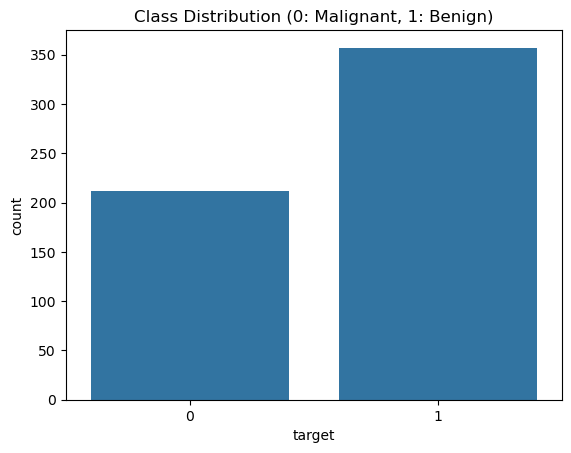

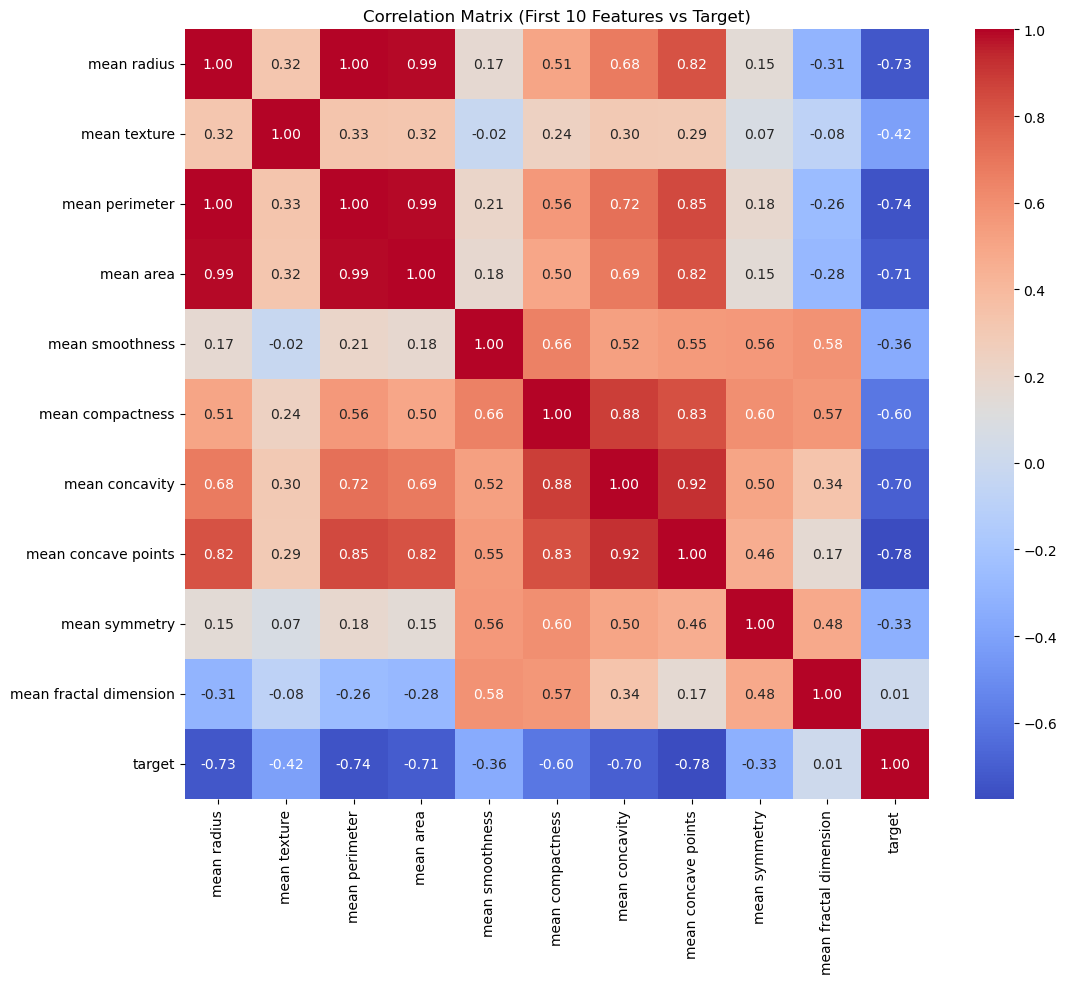

In [2]:
# 1. Data Uploading and Review
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df["target"] = cancer.target

print("Dataset Shape:", df.shape)
print("Number of Missing Values:\n", df.isna().sum().sum()) # Total missing data
print("Number of Duplicate Rows:", df.duplicated().sum())

# Target variable distribution
sns.countplot(x=df["target"])
plt.title("Class Distribution (0: Malignant, 1: Benign)")
plt.show()

# 2. Correlation Analysis
# We only look at the relationship between the first 10 features and the target. (For better readability.)
subset_df = df.iloc[:, :10].copy()
subset_df["target"] = df["target"]
plt.figure(figsize=(12, 10))
sns.heatmap(subset_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (First 10 Features vs Target)")
plt.show()

**EDA Insights:**
* The dataset is clean with no missing values.
* The target classes are relatively balanced (more Benign cases than Malignant), which is good for training.
* **Correlation:** As seen in the heatmap, features like `mean radius`, `mean perimeter`, and `mean area` are highly correlated. This is expected as they are geometrically related.

## 4. Data Preprocessing
### Train-Test Split with Stratification
We split the data into 80% training and 20% testing sets.
* **Note:** We use `stratify=y` to ensure the proportion of Malignant/Benign cases remains the same in both sets.

### Feature Scaling (Standardization)
**Why Scale?** k-NN calculates the distance between data points. Features with larger ranges (e.g., Area ~ 1000) would dominate features with smaller ranges (e.g., Smoothness ~ 0.1).
* We use `StandardScaler` to transform features to have a mean of 0 and a standard deviation of 1.
* **Important:** We fit the scaler *only* on the training set to prevent data leakage.

In [3]:
# 3. Data Preprocessing
X = cancer.data   # features
y = cancer.target # target

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
# Since KNN is distance based, scaling is important.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Model Training & Hyperparameter Tuning
Choosing the right 'k' (number of neighbors) is critical.
* **Small k:** High variance, sensitive to noise (Overfitting risk).
* **Large k:** High bias, smoothes decision boundaries too much (Underfitting risk).

We will iterate through `k=1` to `k=20` to find the value that yields the highest accuracy on the test set.

In [4]:
# 4. Model Training and Hyperparameter Tuning
accuracy_values = []
k_values = []

# Try k values ​​from 1 to 20
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_temp = knn.predict(X_test)
    accuracy_values.append(accuracy_score(y_test, y_pred_temp))
    k_values.append(k)

# Find the best K value
best_k = k_values[np.argmax(accuracy_values)]
print(f"Best k value found: {best_k}")

Best k value found: 3


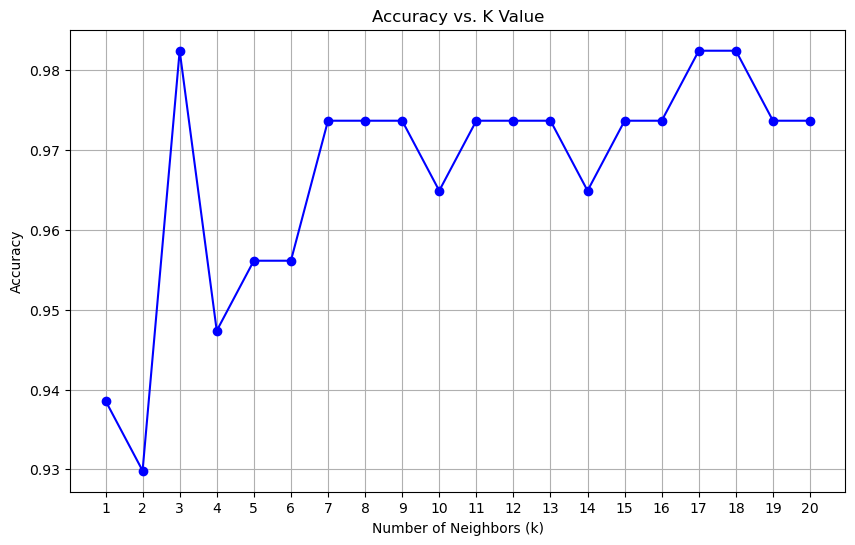

In [5]:
# Plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker="o", linestyle="-", color="b")
plt.title("Accuracy vs. K Value")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [6]:
# 5. Final Model and Evaluation
# We build the final model with the best K value
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)

print("\n--- Final Results ---")
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\Classification Report:\n", classification_report(y_test, y_pred))


--- Final Results ---
Accuracy Score:  0.9824561403508771

Confusion Matrix:
 [[40  2]
 [ 0 72]]
\Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## 6. Conclusion & Evaluation
The model achieved a high accuracy with the optimized 'k' value.

**Contextual Analysis:**
In medical diagnostics, **Recall** is often more important than Precision.
* **False Negative (Type II Error):** Diagnosing a cancerous patient as "Healthy". This is dangerous.
* **False Positive (Type I Error):** Diagnosing a healthy patient as "Cancerous". This causes stress but leads to further tests.

Looking at the classification report above, we aim for a high Recall score for the Malignant class (0) to minimize missed diagnoses.